# Finetuning a Pretrained Model

The pretrained model usually captures general chemistry rules and as such is best trained on a diverse set of molecules (see [pretraining](./pretraining.ipynb)). However, in drug discovery we usually want to bias such a model to a more focused area of chemical space, which is what happens during finetuning. In this tutorial, we will use the finetuning data sets created [previously](./datasets.ipynb) to bias an already existing model. The pretrained models we will use are already placed in the `jupyter/models/pretrained` folder.

## Finetuning a Graph-Based Model

The particular model for this tutorial is pretrained on the ChEMBL database (version 27) with its states saved at `jupyter/models/pretrained/graph/chembl27/chembl27_graph.pkg`. However, before we can load its states the model needs to be initialized so we will need the vocabulary of the model first, which is saved alongside it:

In [1]:
from drugex.data.corpus.vocabulary import VocGraph

vocabulary = VocGraph.fromFile('jupyter/models/pretrained/graph/chembl27/chembl27_graph_voc.txt')
vocabulary

/home/martin/miniconda3/envs/drugex/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we can initialize the model and load the saved states:

In [2]:
from drugex.training.models.transform import GraphModel

pretrained = GraphModel(voc_trg=vocabulary, use_gpus=(6,7)) # attach this model to only the first GPU, but more can be specified
pretrained.loadStatesFromFile('jupyter/models/pretrained/graph/chembl27/chembl27_graph.pkg')

Next, we need to load our finetuning data we created in the [previous tutorial](datasets.ipynb):

In [3]:
from drugex.data.datasets import GraphFragDataSet

finetuning_data_train = GraphFragDataSet("data/sets/graph/ligand_train.tsv")
finetuning_data_test = GraphFragDataSet("data/sets/graph/ligand_test.tsv")

We can verify the data has been loaded by converting it to pandas `DataFrame`:

In [4]:
finetuning_data_train.getData()

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C390,C391,C392,C393,C394,C395,C396,C397,C398,C399
0,1,0,0,0,1,18,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,18,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,18,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2337,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2338,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2339,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2340,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
finetuning_data_test.getData()

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C390,C391,C392,C393,C394,C395,C396,C397,C398,C399
0,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
288,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
289,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
290,1,0,0,0,1,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Finally, we can proceed to finetuning the model (note that we need to transform the `DataSet` to `DataLoader` and specify the batch size):

In [6]:
from drugex.training.monitors import FileMonitor
import pandas as pd
import numpy as np

monitor = FileMonitor('data/models/finetuned/graph/chembl_ligand', verbose=True)
pretrained.fit(
    finetuning_data_train.asDataLoader(128), # create the data loader and specify the batch size
    finetuning_data_test.asDataLoader(128), 
    epochs=3, # only 3 epochs to make things faster
    monitor=monitor
)

print("Finetuning done.")

100%|██████████| 3/3 [00:49<00:00, 16.44s/it]


Finetuning done.


If you want to follow the training progress, you can periodically check the `data/models/finetuned/chembl_ligand_fit.log` file that is created by the `FileMonitor` along with other files and also the states of the best performing model. The `FileMonitor` is useful when you want to analyze the data generating during training later. You can load these files easily as pandas data frames:

In [7]:
# training summary with mean training loss and validation loss
df_info = pd.read_csv('data/models/finetuned/graph/chembl_ligand_fit.tsv', sep='\t')
df_info

,epoch,loss_valid,valid_ratio,unique_ratio,desire_ratio,mean_train_loss
0,1,5.797196,1.0,NaN,NaN,2.045352
1,2,5.410049,1.0,NaN,NaN,1.956686
2,3,4.902671,1.0,NaN,NaN,1.819884


In [8]:
# smiles generated at each epoch from the validation set and the input fragment(s) used to generate each
df_smiles = pd.read_csv('data/models/finetuned/graph/chembl_ligand_smiles.tsv', sep='\t')
df_smiles.head()

,SMILES,Valid,Frags,Epoch
0,CC(C)CN1C(c2cnc(N)nc2)=CC2C(C)N(CC3Cc4ccccc4CN...,1.0,c1ccccc1,1
1,Cc1ccccc1N=C(SC1CC(=O)NC1C(N)=O)C(=O)N1CCc2ccc...,1.0,c1ccccc1,1
2,CCCCC(C)NC(=O)C1CC2C(=O)C1(C)CC2COC(=O)c1ccccc1,1.0,c1ccccc1,1
3,COc1ccc(C=C(C(=O)C(N)=O)c2nc(-c3ccc(Cl)c(Cl)c3...,1.0,CO.Clc1ccccc1Cl.c1nc[nH]n1,1
4,CCCCCCC=Cc1ccc2c(c1)CCN2,1.0,c1ccccc1,1


With these data, we can easily generate a model performance plot for each epoch:

<AxesSubplot:>

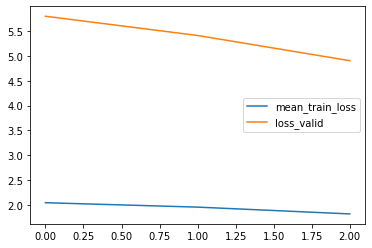

In [9]:
df_info[['mean_train_loss', 'loss_valid']].plot.line()

The monitor also enables us to get the best model's states for initialization of a new instance for generation or another round of finetuning:

In [10]:
ft_model = monitor.getModel()
ft_model['emb_word.weight']

tensor([[-0.0205, -0.0666, -0.0142,  ...,  0.0925,  0.0784,  0.0773],
        [ 0.0902,  0.0458, -0.0819,  ..., -0.0799,  0.0197,  0.0698],
        [ 0.0079, -0.0163,  0.0373,  ..., -0.0541,  0.0064, -0.0043],
        ...,
        [ 0.0149, -0.0912,  0.1480,  ...,  0.0100,  0.0516, -0.0902],
        [ 0.1013,  0.1127, -0.1173,  ...,  0.2811, -0.1796, -0.0870],
        [ 0.1036, -0.0346,  0.0283,  ..., -0.0144, -0.0385, -0.1008]],
       device='cuda:6')

In [11]:
other_model = GraphModel(voc_trg=vocabulary)
other_model.load_state_dict(ft_model)

<All keys matched successfully>

For consistency, we will also save the used vocabulary with the model so that we can always initialize it exactly the way we did during finetuning:

In [12]:
vocabulary.toFile('data/models/finetuned/graph/ligand_finetuned.vocab')